# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F



### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
#BLACKBOX_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["Cat", "Dog"]

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
#if not Path(BLACKBOX_CLASSIFIER_WEIGHT_PATH):
#    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

# Demo: ImageObject Class

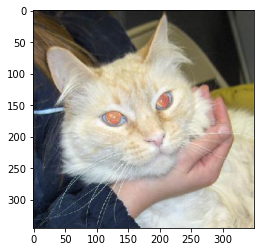

In [2]:
#pick random cat image
random_cat_image = get_image(CAT_IMG_PATH)
ImageObjectDemo = our_lime.ImageObject(random_cat_image)
ImageObjectDemo.show()

# Demo: SegmentationMethod Class

In [3]:
explainer = our_lime.Explainer(
    our_lime.SegmentationMethod("quickshift")
)
explainer.segment_image(ImageObjectDemo, kernel_size=4, max_dist=200, ratio=0.2 )
#superpixels are saved
ImageObjectDemo.superpixels

array([[ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  3,  3,  3],
       ...,
       [63, 63, 63, ..., 70, 70, 70],
       [63, 63, 63, ..., 70, 70, 70],
       [63, 63, 63, ..., 70, 70, 70]], dtype=int64)

# Demo: Generate Mask

None


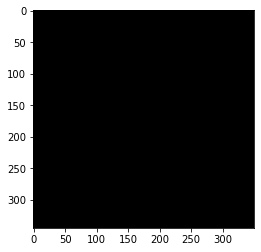

In [7]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

0


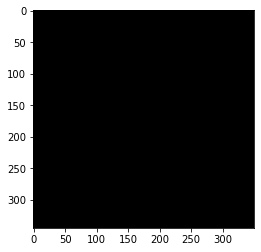

In [8]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

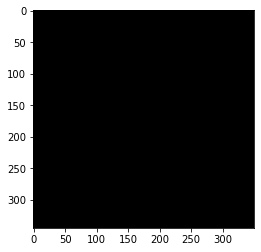

In [9]:
plt.imshow(ImageObjectDemo.original_image)